In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

!pip install geocoder

# импортируем библиотеки для определения геопозиции
import geocoder



# импорт регулярок
import re

# импорт модуля управления датами и временем
from datetime import datetime as dt
import datetime

# импортируем контейнер типов данных
import collections

# импорт модуля кодирования категориальных значений
import category_encoders as ce

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 3.2 MB/s eta 0:00:00
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:

In [2]:
!pip freeze > requirements.txt 

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# Загрузим данные из соревнования

In [4]:
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
df_train.info() # смотрим состав датасета для обучения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2) # знакомимся с данными датасета для обучения

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info() # смотрим состав датасета для предсказания

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2) # знакомимся с данными датасета для предсказания

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2) # знакомимся с данными датасета самбмишн

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info() # смотрим состав датасета самбмишн

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


# Поиск дублей

In [11]:
mask = df_train.duplicated(subset=df_train.columns) # маска для фильтрации
data_duplicates = df_train[mask] # фильтруем наш датасет
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 307


In [12]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

/tmp/ipykernel_20/1819849330.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [13]:
data.info() # смотрим состав объединенного датасета

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [14]:
# Преобразуем строковое значение количества дней между датой проверки и датой очистки в числовое
data['days_since_review'] = data['days_since_review'].apply(lambda value: np.int64(re.search('\d+', value).group(0)))
data['days_since_review']

0          13
1         234
2         616
3         656
4         444
         ... 
515733    106
515734    171
515735    543
515736     74
515737    363
Name: days_since_review, Length: 515738, dtype: int64

# Заполняем пропуски в данных координат в DataFrame 'data'

In [15]:
# Получаем список адресов отелей с координатами
hotels_df = data[['hotel_address','lat','lng']].groupby(by=['hotel_address'],as_index=True).mean()

# Определяем недостающие координаты отелей
for i in hotels_df[hotels_df['lat'].isnull()].index:
    g =geocoder.arcgis(i) # Делаем запрос координат через модуль geocoder
    hotels_df.at[i,'lat'] = g.latlng[0]
    hotels_df.at[i,'lng'] = g.latlng[1]

# Разбираем 'addres' на страну и адрес
hotels_df['country'] = ''
hotels_df['addres'] = hotels_df.index
hotels_df['country'] = hotels_df['addres'].apply(lambda x: x.split(' ')[-1] if (x.split(' ')[-1] != 'Kingdom') else (x.split(' ')[-2]+' '+x.split(' ')[-1]))

# Преобразуем данные в словарь
coord_dict = hotels_df.to_dict(orient='index')
    
# Заполняем координаты в DataFrame'е
for i in data[data['lat'].isnull()].index:
    data.at[i,'lat'] = coord_dict[data['hotel_address'][i]]['lat']
    data.at[i,'lng'] = coord_dict[data['hotel_address'][i]]['lng']
        
# Определяем являются ли отели сетевыми
data['hotel_net'] = data['hotel_name'].apply(
    lambda x: re.search(r'Mercure|Golden Tulip|Holiday Inn|Golden Tulip|Radisson|Best Western|DoubleTree',x)[0] \
    if (re.search(r'Mercure|Golden Tulip|Holiday Inn|Golden Tulip|Radisson|Best Western|DoubleTree',x) is not None) \
    else 'Not_in_net'
    )
    
# Выделяем страну в отдельный столбец
data['country'] = ''
data['country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1] if (x.split(' ')[-1] != 'Kingdom') else (x.split(' ')[-2]+' '+x.split(' ')[-1]))

# Исправляем представление данных о национальности
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x[1:-1])

In [16]:
data.head(2) # убеждаемся в изменениях датасета  

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_net,country
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13,45.533137,9.171102,0,0.0,Not_in_net,Italy
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234,52.385649,4.834443,0,0.0,Not_in_net,Netherlands


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# Добавляем данные: Город(где находится отель), площадь и популяция  

In [18]:
data['hotel_city'] = data['hotel_address'].apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])

сity_population = {
    'Paris':  2148327, 'London': 8908081, 'Milan': 1366180, 
    'Vienna': 1911191, 'Barcelona': 1636732, 'Amsterdam': 860124
}
сity_area = {
    'Paris': 105, 'London': 1706, 'Milan': 181, 
    'Vienna': 414, 'Barcelona': 101, 'Amsterdam': 219
}

data['сity_population'] = data['hotel_city'].map(сity_population)
data['сity_area'] = data['hotel_city'].map(сity_area)

data.drop(['hotel_address'], axis=1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

In [19]:
data['hotel_city'] # Посмотрим на столбец с названием городов

0             Milan
1         Amsterdam
2         Barcelona
3             Milan
4         Amsterdam
            ...    
515733       London
515734       Vienna
515735       London
515736       London
515737       London
Name: hotel_city, Length: 515738, dtype: object

# Посчитаем количество дней с момента опубликования ревью

In [20]:
data['review_date'] = pd.to_datetime(data['review_date'])
now_date = datetime.date.today()

date_1=pd.to_datetime(now_date)
print(date_1)
data['review_date']

2023-06-26 00:00:00


0        2017-07-21
1        2016-12-12
2        2015-11-26
3        2015-10-17
4        2016-05-16
            ...    
515733   2017-04-19
515734   2017-02-13
515735   2016-02-07
515736   2017-05-21
515737   2016-08-05
Name: review_date, Length: 515738, dtype: datetime64[ns]

In [21]:
# рассчитаем количество дней прошедших с ревью
now_date = datetime.date.today()
data['days_with_a_review'] = (date_1 - data['review_date']).dt.days

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   hotel_name                                  515738 non-null  object        
 4   reviewer_nationality                        515738 non-null  object        
 5   negative_review                             515738 non-null  object        
 6   review_total_negative_word_counts           515738 non-null  int64         
 7   total_number_of_reviews                     515738 non-null  int64         
 8   positive_review                             515738 non-null  object       

In [22]:
# Преобразуем дату ревью в признаки
data['year'] = data['review_date'].dt.year
data['month'] = data['review_date'].dt.month
data['day'] = data['review_date'].dt.day
data['dayofweek'] = data['review_date'].dt.dayofweek

In [23]:
# Удаляем столбец с датами
data.drop('review_date', axis = 1, inplace=True)

# Корректировка информации о национальности ревьюера. Также мы преобразуем национальность в признак

In [24]:
# Поправим данные о ревьюере из США
us_list = ['Jersey','United States of America']
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: 'United States' if x in us_list else x)

# Преобразуем национальность ревьюера в признак
nat_list = []
for i in data.index:
    nat_list.append(data['reviewer_nationality'][i]) 
nat_cnt = collections.Counter(nat_list)

top_nat_set = set([key for key, _ in nat_cnt.most_common(5)])
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_nat_set else 'other')
data['reviewer_nationality'].describe()

count             515738
unique                 6
top       United Kingdom
freq              245246
Name: reviewer_nationality, dtype: object

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

In [26]:
data.nunique(dropna=False)

additional_number_of_scoring                     480
average_score                                     34
hotel_name                                      1492
reviewer_nationality                               6
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1488
lng                                             1488
sample                                             2
reviewer_score                                    38
hotel_net                                          7
country                                            6
hotel_city                                    

# Кодировка признаков

Сделаем кодировку признаков 'hotel_city', 'hotel_net' и 'country' методом однократного кодирования (так как количество значений незначительное). Исходный признак удаляем.

In [27]:
encoder = ce.OneHotEncoder(cols=['hotel_city'])
type_bin_city = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin_city], axis=1)

encoder = ce.OneHotEncoder(cols=['hotel_net'])
type_bin_net = encoder.fit_transform(data['hotel_net'])
data = pd.concat([data, type_bin_net], axis=1)

encoder = ce.OneHotEncoder(cols=['country'])
type_bin_country = encoder.fit_transform(data['country'])
data = pd.concat([data, type_bin_country], axis=1)

data.drop(['hotel_city', 'hotel_net', 'country'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

Сделаем кодировку признаков 'reviewer_nationality' и 'hotel_name' методом двоичного кодирования (так как количество значений более 200). Исходный признак удаляем.

In [28]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
type_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, type_bin], axis=1)

data.drop(['reviewer_nationality', 'hotel_name'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 54 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   negative_review                             515738 non-null  object 
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   positive_review                             515738 non-null  object 
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   tags                                        515738 non-null  object 
 9   days_since_review                           515738 non-null  int64  
 

# Посмотрим на корреляцию получившихся признаков

/tmp/ipykernel_20/1624597386.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)


<Axes: >

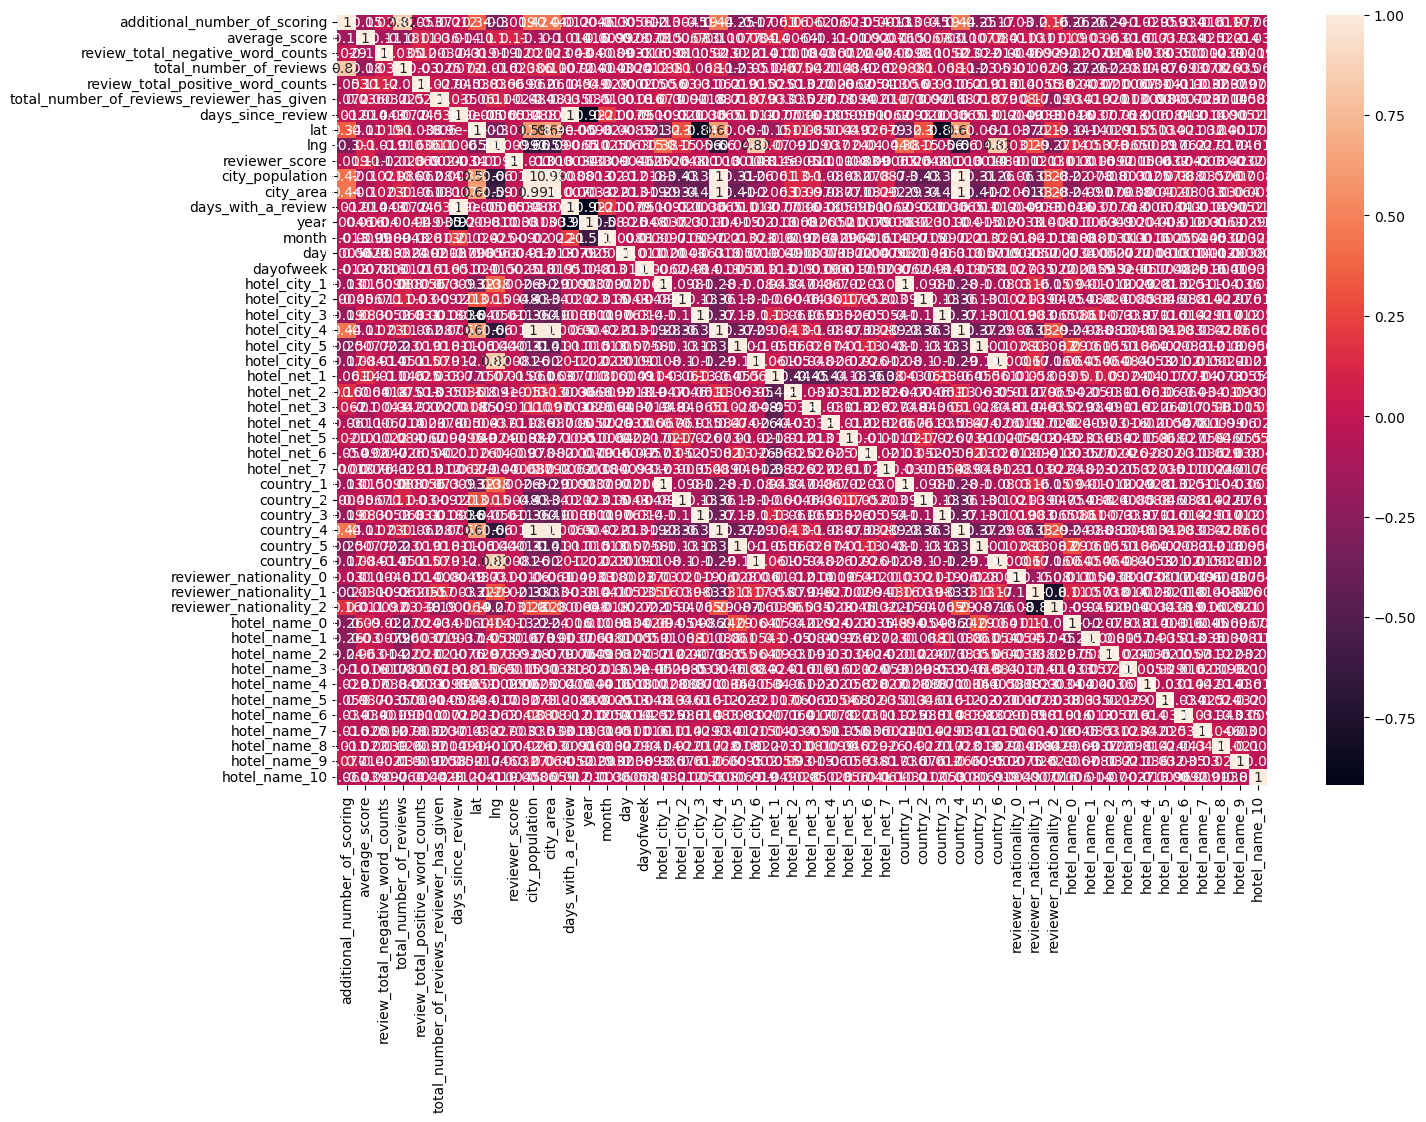

In [29]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

ввиду того что наблюдается корреляция между признаками 'country', 'city', 'сity_area' и 'days_since_review', удаляем лишние признаки 

In [30]:
data.drop(['country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 'days_since_review', 'сity_area'], axis=1, inplace=True)

# Проверим корреляцию

/tmp/ipykernel_20/1624597386.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)


<Axes: >

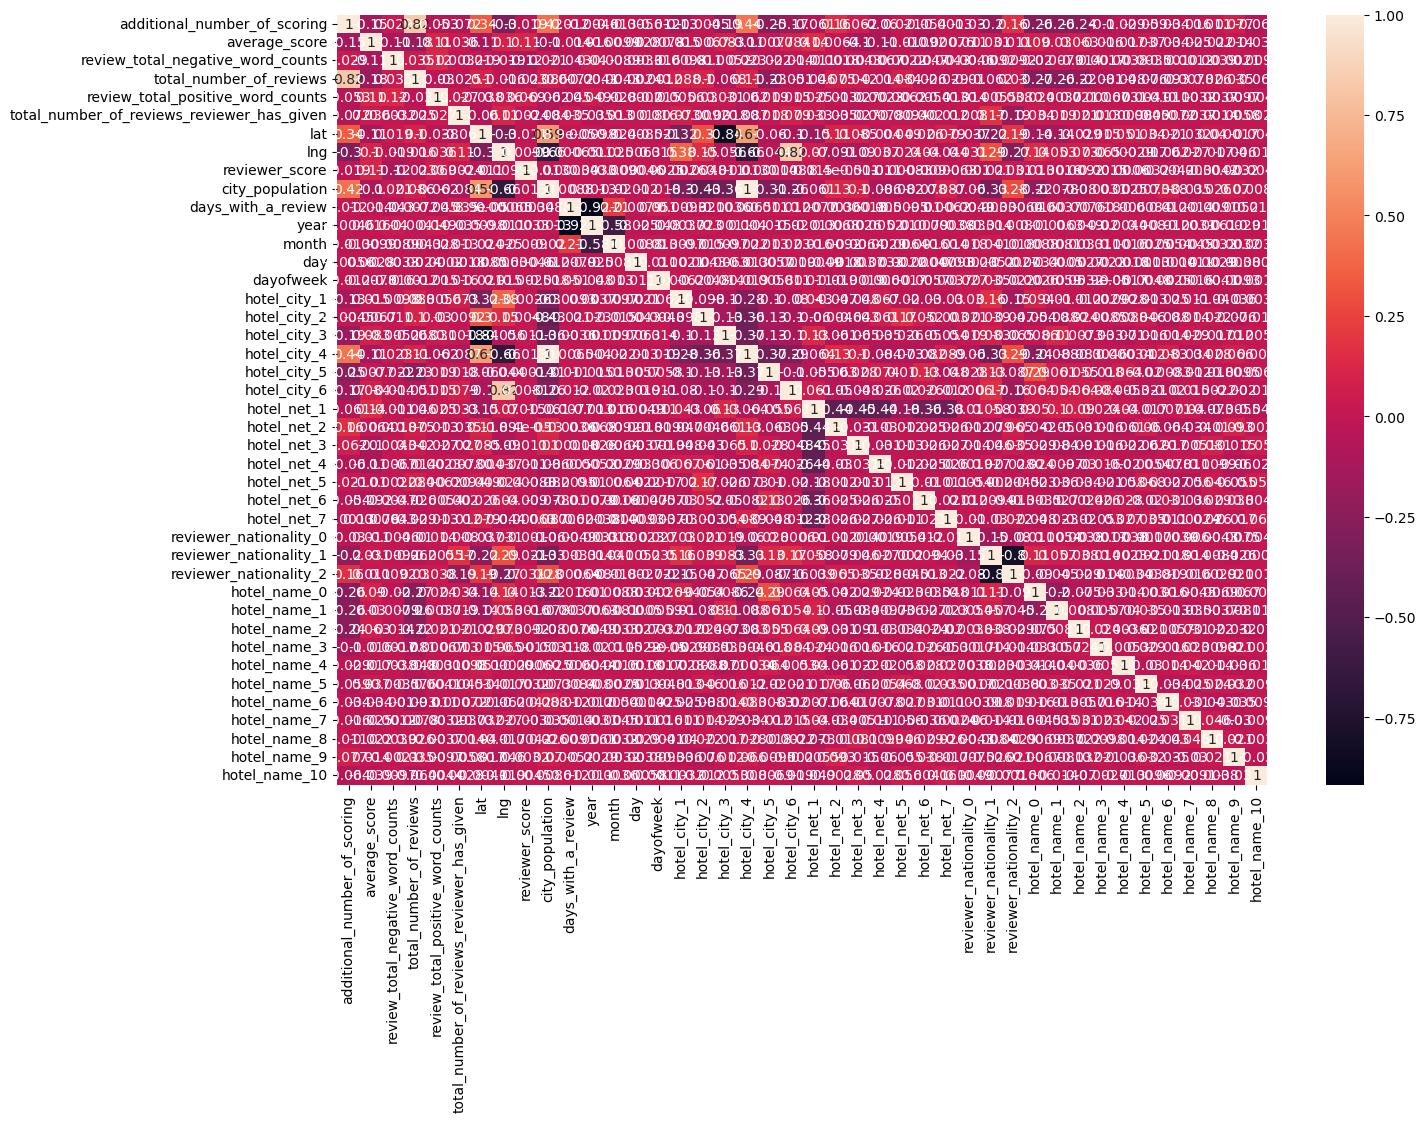

In [31]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [32]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 43 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

In [34]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [35]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [36]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 42), (386803, 42), (386803, 41), (309442, 41), (77361, 41))

In [37]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [38]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [39]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [40]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9442548296145279


<Axes: >

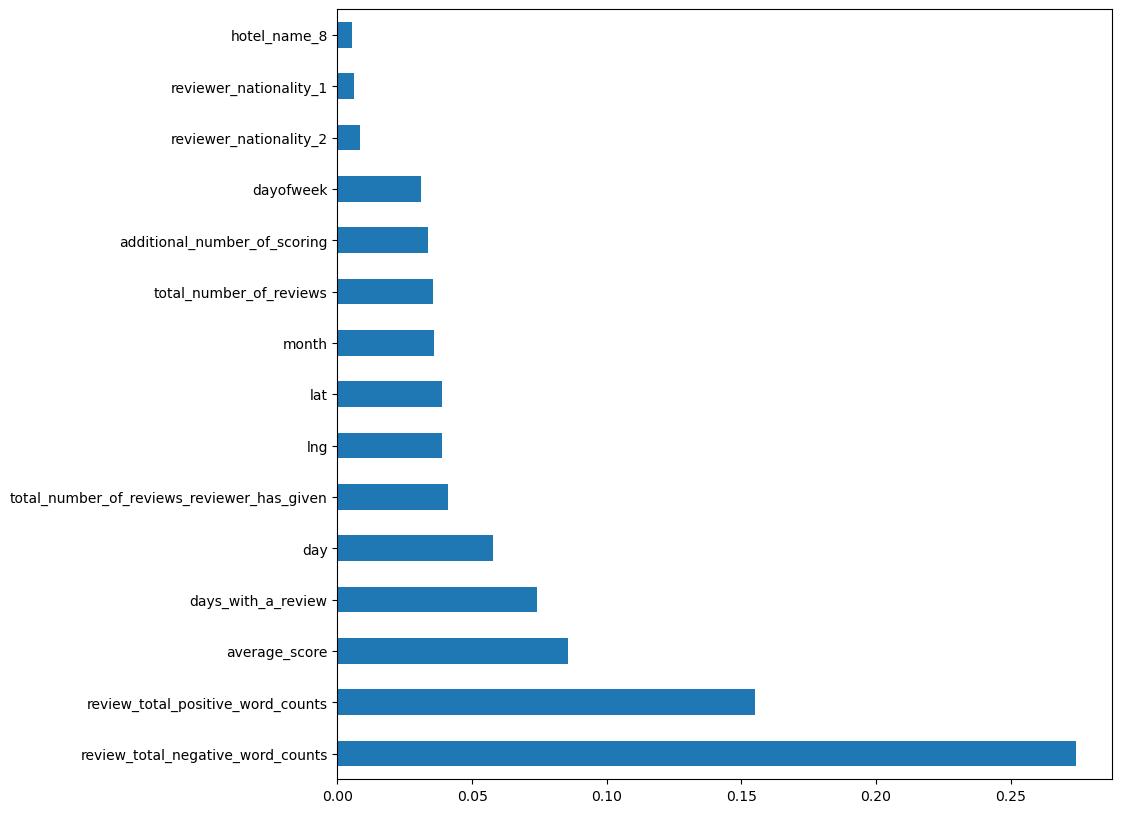

In [41]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [42]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,сity_population,...,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10
3315,230,8.6,9,1703,65,1,48.872059,2.323680,0.0,2148327,...,1,0,1,1,1,0,1,1,1,1
9207,94,9.2,3,969,3,4,48.207158,16.376591,0.0,1911191,...,1,0,1,1,0,0,0,0,1,1
112722,160,8.1,0,1560,34,7,41.410131,2.218805,0.0,1636732,...,1,0,0,1,0,1,1,0,0,0
83800,293,8.7,0,1908,26,1,41.379921,2.172818,0.0,1636732,...,1,1,0,0,1,1,0,1,0,0
91086,224,8.6,8,2351,11,1,45.484137,9.200162,0.0,1366180,...,0,0,1,1,0,0,1,1,0,1
82251,122,8.5,36,1686,11,27,45.486700,9.157514,0.0,1366180,...,1,1,0,1,0,1,0,0,0,0
11279,713,8.3,35,2826,22,5,51.524139,-0.138081,0.0,8908081,...,0,0,0,1,1,0,1,1,0,1
47961,612,8.6,74,5018,15,10,52.385649,4.834443,0.0,860124,...,0,0,0,0,0,0,0,0,1,0
90223,118,7.2,14,1168,0,2,48.869176,2.320581,0.0,2148327,...,0,0,0,0,1,0,0,1,1,0
55798,930,8.9,0,2836,6,7,51.507271,-0.021121,0.0,8908081,...,0,0,1,0,1,0,1,0,1,0


In [43]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [44]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [45]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.5s finished


In [46]:
predict_submission

array([8.521, 7.182, 8.037, ..., 7.806, 9.417, 6.848])

In [47]:
list(sample_submission)

['reviewer_score', 'id']

In [48]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.521,488440
1,7.182,274649
2,8.037,374688
3,9.489,404352
4,9.668,451596
5,8.892,302161
6,7.946,317079
7,7.533,13963
8,8.457,159785
9,8.266,195089
